In [48]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


training images: 60.000
test images: 10.000

image shape: (28, 28, 1)

pixel values: 0 - 255

In [49]:
#tfds.show_examples(train_ds, ds_info)

In [50]:
def prepare_mnist_data(mnist):
  #flatten the images into vectors
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)
  #return preprocessed dataset
  return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

In [51]:
class Dense(tf.keras.layers.Layer):

    def __init__(self, n_units, activation, **kwargs):
        super(Dense, self).__init__(**kwargs)
        # no variables created
        self.n_units = n_units
        self.activation = activation

    def build(self, input_shape):
        self.w = tf.Variable(tf.random.normal([input_shape[-1], self.n_units]), name='weights')
        self.b = tf.Variable(tf.zeros([self.n_units]), name='bias')

    def call(self, inputs):
        x = inputs @ self.w + self.b
        return self.activation_function(x)


In [70]:
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = Dense(20, activation=tf.nn.relu)
        self.dense2 = Dense(20, activation=tf.nn.relu)
        self.dense3 = Dense(20, activation=tf.nn.relu)
        self.out = Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.out(x)
        return x

In [71]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [72]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.09625
Epoch: 1 starting with accuracy 0.344375
Epoch: 2 starting with accuracy 0.540625
Epoch: 3 starting with accuracy 0.6953125
Epoch: 4 starting with accuracy 0.7828125
Epoch: 5 starting with accuracy 0.8265625
Epoch: 6 starting with accuracy 0.8453125
Epoch: 7 starting with accuracy 0.864375
Epoch: 8 starting with accuracy 0.86875
Epoch: 9 starting with accuracy 0.8828125


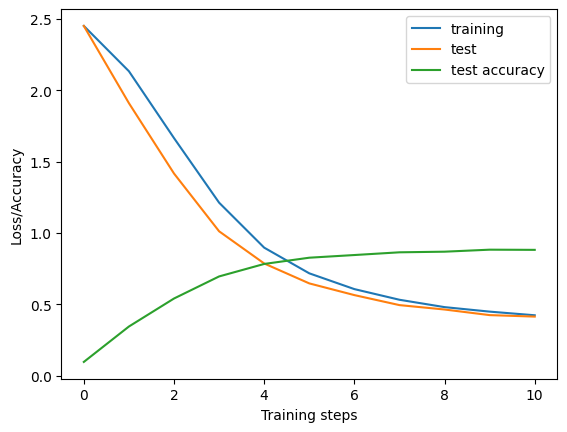

In [73]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()

Original setup:

learning_rate = 0.001;
batch_size = 32;
num_layers = 3;
size_layers = [256, 256, 10];
optimizer = SGD


output:

Epoch: 0 starting with accuracy 0.1

Epoch: 1 starting with accuracy 0.803125

Epoch: 2 starting with accuracy 0.853125

Epoch: 3 starting with accuracy 0.87375

Epoch: 4 starting with accuracy 0.885

Epoch: 5 starting with accuracy 0.8871875

Epoch: 6 starting with accuracy 0.8946875

Epoch: 7 starting with accuracy 0.8978125

Epoch: 8 starting with accuracy 0.9021875

Epoch: 9 starting with accuracy 0.9034375




Change learning rate to learning_rate = 0.005

Output:

Epoch: 0 starting with accuracy 0.0875

Epoch: 1 starting with accuracy 0.8909375

Epoch: 2 starting with accuracy 0.90875

Epoch: 3 starting with accuracy 0.9215625

Epoch: 4 starting with accuracy 0.93125

Epoch: 5 starting with accuracy 0.9309375

Epoch: 6 starting with accuracy 0.933125

Epoch: 7 starting with accuracy 0.9375

Epoch: 8 starting with accuracy 0.9371875

Epoch: 9 starting with accuracy 0.9446875

When the learning rate increases, the accuracy in every epoch increases more than with the original learning rate. This was to be expected because the learning rate defines the step size by which we adjust the weights (as a factor for the calculated gradient loss)

Change number of layers to num_layers = 4 (with num_units = 256)

Epoch: 0 starting with accuracy 0.136875

Epoch: 1 starting with accuracy 0.8234375

Epoch: 2 starting with accuracy 0.86

Epoch: 3 starting with accuracy 0.881875

Epoch: 4 starting with accuracy 0.888125

Epoch: 5 starting with accuracy 0.89625

Epoch: 6 starting with accuracy 0.9028125

Epoch: 7 starting with accuracy 0.90125

Epoch: 8 starting with accuracy 0.90375

Epoch: 9 starting with accuracy 0.9028125

The network shows a very similar learning behavior, which intuitively seemed quite surprising to me. However, as the 3 layered network already performes very well in this task, the extra layer cannot significantly improve the models performance. I would expect that this is due to the quite simple complexity of the task and if the inputs were more complex images for example, then an extra layer would show more efficiently.


Change size of layers to size_layers = [20, 20, 10]

Output:

Epoch: 0 starting with accuracy 0.0953125

Epoch: 1 starting with accuracy 0.3525

Epoch: 2 starting with accuracy 0.6828125

Epoch: 3 starting with accuracy 0.778125

Epoch: 4 starting with accuracy 0.8128125

Epoch: 5 starting with accuracy 0.8409375

Epoch: 6 starting with accuracy 0.855625

Epoch: 7 starting with accuracy 0.860625

Epoch: 8 starting with accuracy 0.8703125

Epoch: 9 starting with accuracy 0.8784375

The network with less units learns slower but as also the bigger network begins stagnating after having reached an accuracy of about 0.80, the same happens in the smaller network. The difference is the higher number of epochs here. I suggest that this lower learning effect is due to the smaller representational space. A network with more units can represent more complex patterns.

Diminish size of layers but increase number of layers, so num_layers = 4, size_layers = [20, 20, 20, 10]

Epoch: 0 starting with accuracy 0.09625

Epoch: 1 starting with accuracy 0.344375

Epoch: 2 starting with accuracy 0.540625

Epoch: 3 starting with accuracy 0.6953125

Epoch: 4 starting with accuracy 0.7828125

Epoch: 5 starting with accuracy 0.8265625

Epoch: 6 starting with accuracy 0.8453125

Epoch: 7 starting with accuracy 0.864375

Epoch: 8 starting with accuracy 0.86875

Epoch: 9 starting with accuracy 0.8828125


This output is very similar to the one where I only decreased the number of units per layer. Therefore, the effect of an additional layer in this network is minimal, even with less units. It seems that the task complexity is "too low" in order to make use of more depth.